<a href="https://colab.research.google.com/github/lochieh19798/Data-analysis/blob/main/Figure2mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edition control

In [127]:
!git config --global user.name "lochieh19798"
!git config --global user.email "lochieh19798@gmail.com"

In [128]:
!git clone https://github.com/lochieh19798/data-analysis

fatal: destination path 'data-analysis' already exists and is not an empty directory.


In [129]:
# ╔═╡ Cell 0 ═════════════════════════════════════════════════════════════╗
# If you’re on Colab, install any non-preinstalled libraries:
!pip install -q catboost shap scikit-learn==1.4.2 matplotlib pandas numpy
!pip install -q --upgrade xgboost
!pip install -q shap --no-deps

In [130]:
from xgboost.sklearn import XGBModel
XGBModel.feature_weights = None
print("Patched XGBModel.feature_weights →", XGBModel.feature_weights)

Patched XGBModel.feature_weights → None


In [131]:
# ╔═╡ Cell 1 ═════════════════════════════════════════════════════════════╗
# Imports & global configuration
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import display

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer
    # ← no IterativeImputer here
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
plt.style.use("default")


In [132]:
# ╔═╡ Cell 2 – load data & build feature lists with missing‐% report ═════╝
from pathlib import Path
import pandas as pd

# 1. Data‐loading helper (as before)
DATA_PATH = "/content/data-analysis/CRYOANALYSIS.csv"
def load_and_prepare_data(csv_path: str = DATA_PATH) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # (1) Recurrence flags
    df["Survival_time"] = pd.to_numeric(df["Survival_time"], errors="coerce")
    df = df.dropna(subset=["Survival_time", "Recurrence"])
    df["Recurrence_1yr"] = ((df["Survival_time"] <= 365) & (df["Recurrence"] == 1)).astype(int)
    df["Recurrence_2yr"] = ((df["Survival_time"] <= 730) & (df["Recurrence"] == 1)).astype(int)
    # (2) AF type one‐hot
    af_col = "Baseline AF Type(1=paroxysmal, 2=persistent)"
    df["AF_Parox"]   = (df[af_col] == 1).astype(int)
    df["AF_Persist"] = (df[af_col] == 2).astype(int)
    return df

# 2. Load the dataset
DATA_PATH = Path("/content/data-analysis/CRYOANALYSIS.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found – upload it first!"
df = load_and_prepare_data(DATA_PATH)

# 3. Feature lists
cont = [
    "age", "BMI",
    "Baseline LVEF", "Baseline LAD", "CHA2DS2VASc score", "CHAD2 score", "AF_time_procedure",
    "Total no of ablation application number", "Mobility question (Baseline)",
    "Self-care question (Baseline)", "Usual activities question (Baseline)",
    "Pain/Discomfort question (Baseline)", "Anxiety/Depression question (Baseline)",
    "Visual analogue score: Your own health state today (Baseline)",
    "Total procedure time: Venous access to last cryoatheter removal (mins)",
    "Total fluoro time (mins)", "Energy duration LSPV", "Coldest Temperature LSPV",
    "Energy duration LIPV", "Coldest Temperature LIPV",
    "Energy duration RSPV", "Coldest temperature RSPV",
    "Energy duration RIPV", "Coldest Temperature RIPV",
    "Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)",
    "Change in EQ 5D"
    # "Time to isolation LSPV", "Time to isolation LIPV", "Time to isolation RSPV","Time to isolation RIPV",
]

cat = [
    "Sex (F=1, M=0)", "Hypertension", "Diabetes", "HF", "CAD", "stroke",
    "History of TIA", "Subject taking Class I or III AAD at baseline (1=Yes, 0=No)",
    "LSPV isolated", "LIPV PV isolated", "RSPV Isolated", "RIPV isolated",
    "Were all targeted PVs isolated (Investigator)?",
    "AF_Parox", "AF_Persist",
    "CTI ablation",
    "Non-PVI ablation performed",
    "Was subject taking Class I or Class III AAD at procedure discharge?",
    "Mapping/navigational tools: Intracardiac echocardiography (ICE)",
    "Pre Procedural CT",
    "Ensite 3D mapping"
]

TARGET = "Recurrence_2yr"

# 4. Report missing‐value percentages for every feature
all_feats = cont + cat
missing_pct = df[all_feats].isna().mean() * 100
missing_report = (
    missing_pct
      .sort_values(ascending=False)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "variable"})
)
print("📊 Missing Value Percentage per Feature:")
print(missing_report.to_string(index=False, float_format="%.1f%%"))

# 5. Gentle column check: warn & drop if still missing
missing_cont = [c for c in cont if c not in df.columns]
missing_cat  = [c for c in cat  if c not in df.columns]
if missing_cont or missing_cat:
    print("\n⚠️  WARNING – some expected columns are missing and will be skipped.")
    print("   Missing continuous :", missing_cont)
    print("   Missing categorical:", missing_cat)

cont = [c for c in cont if c in df.columns]
cat  = [c for c in cat  if c in df.columns]

# From here on, the rest of the notebook runs as before...


📊 Missing Value Percentage per Feature:
                                                                                          variable  missing_pct
                                                                                      Baseline LAD        32.7%
                                                                                   Change in EQ 5D        27.0%
                                                            Anxiety/Depression question (Baseline)        25.6%
                                                               Pain/Discomfort question (Baseline)        25.6%
                                                              Usual activities question (Baseline)        25.6%
                                                                     Self-care question (Baseline)        25.6%
                                     Visual analogue score: Your own health state today (Baseline)        25.6%
                                                                

In [133]:
# ╔═╡ Cell 3 – stratified 3-way split: train/test/validation ═══════════╗
from sklearn.model_selection import train_test_split

# 1) Sort by date if you still want a temporal ordering internally (optional)
df["ProcedureDate"] = pd.to_datetime(df["ProcedureDate"])
df_sorted = df.sort_values("ProcedureDate")

# 2) Extract features & target
X_all = df_sorted[cont + cat]
y_all = df_sorted[TARGET].astype(int)

# 3) Initial 20% hold-out for future validation (stratified by target)
X_temp, X_val, y_temp, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=RANDOM_STATE
)

# 4) Of the remaining 80%, take a 20% slice for an internal test set
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.20,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

# 5) Report sizes and event rates
print("Split sizes:")
print(f"  • Train:      {len(y_train)}")
print(f"  • Test:       {len(y_test)}")
print(f"  • Validation: {len(y_val)}\n")

print("Event rates:")
print(f"  • Overall:    {y_all.mean():.2%}")
print(f"  • Train:      {y_train.mean():.2%}")
print(f"  • Test:       {y_test.mean():.2%}")
print(f"  • Validation: {y_val.mean():.2%}")


Split sizes:
  • Train:      179
  • Test:       45
  • Validation: 57

Event rates:
  • Overall:    19.22%
  • Train:      18.99%
  • Test:       20.00%
  • Validation: 19.30%


In [134]:
# ╔═╡ Cell 4 – Pre-processing pipelines ═══════════════════════════════════╗
# (Make sure to enable the experimental IterativeImputer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline           import Pipeline
from sklearn.impute             import IterativeImputer, SimpleImputer
from sklearn.preprocessing      import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose            import ColumnTransformer

# Numeric pipeline: iterative imputation → power transform → scaling
numeric_pipe = Pipeline([
    ("impute", IterativeImputer(random_state=RANDOM_STATE)),
    ("power",  PowerTransformer(method="yeo-johnson")),
    ("scale",  StandardScaler())
])

# Categorical pipeline: fill missing with "Missing" → one-hot encode
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Full preprocessor: apply to continuous and categorical lists
preprocessor = ColumnTransformer([
    ("num", numeric_pipe,       cont),
    ("cat", categorical_pipe,   cat)
], remainder="drop")


In [135]:
# ╔═╡ Cell 4b – preview IterativeImputer + PowerTransformer on numeric features ═══════╗
import warnings
from sklearn.exceptions import ConvergenceWarning

# (Optionally suppress FutureWarnings or ConvergenceWarnings)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Show missing counts before
num_train = X_train[cont].copy()
print("🔴 Missing before imputation (numeric features):")
print(num_train.isna().sum())

# 2. Fit & transform with your updated numeric_pipe
num_imputed = pd.DataFrame(
    numeric_pipe.fit_transform(num_train),
    columns=cont,
    index=num_train.index
)

# 3. Show missing counts after
print("\n🟢 Missing after IterativeImputer + PowerTransformer:")
print(num_imputed.isna().sum())

# 4. Display first few rows of the transformed DataFrame
display(num_imputed.head())


🔴 Missing before imputation (numeric features):
age                                                                                                    0
BMI                                                                                                    1
Baseline LVEF                                                                                         44
Baseline LAD                                                                                          57
CHA2DS2VASc score                                                                                      0
CHAD2 score                                                                                            0
AF_time_procedure                                                                                     18
Total no of ablation application number                                                                0
Mobility question (Baseline)                                                                          41
Self-ca

,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Energy duration LSPV,Coldest Temperature LSPV,Energy duration LIPV,Coldest Temperature LIPV,Energy duration RSPV,Coldest temperature RSPV,Energy duration RIPV,Coldest Temperature RIPV,Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins),Change in EQ 5D
128,0.306690,-2.695985,2.256020,-0.035082,0.816136,1.063746,0.380852,-0.172024,-0.478756,-0.179739,...,-0.169332,-0.541701,0.017336,-0.584491,-0.081233,-1.452025,-0.004267,0.034946,-0.860967,0.401817
154,-0.764668,-1.718153,-1.638789,-0.353458,0.816136,1.063746,-0.311250,0.366003,-0.478756,-0.179739,...,-0.169332,-0.746231,0.017336,0.191863,0.230314,-0.191331,0.880168,0.493780,-0.225780,1.065214
276,0.407181,-3.076736,-0.143123,-0.014944,-1.765314,-1.146417,0.284545,-0.172024,-0.478756,-0.179739,...,-0.169332,1.668595,0.017336,0.778259,0.230314,-0.191331,-0.004267,-1.140601,-0.063261,0.064858
164,-1.277493,0.192692,-0.868812,0.091638,-1.765314,-1.146417,-0.515793,0.366003,-0.478756,-0.179739,...,-0.169332,1.230503,1.482320,-0.197069,0.230314,0.322677,-0.004267,0.649173,0.015393,0.064858
56,-0.434878,-1.450036,0.353945,-1.285939,-0.565279,-1.146417,0.126799,-0.172024,0.494720,-0.320770,...,-0.169332,0.085402,0.017336,-0.311874,0.230314,-0.662338,-0.004267,-0.698509,-1.285353,0.187132


In [136]:
# ╔═╡ Cell 4c – preview string-cast → impute → one-hot on categorical features ═══════╗
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import FunctionTransformer, OneHotEncoder
from sklearn.impute            import SimpleImputer
import pandas as pd

# 1) Re-define categorical_pipe to cast → impute → one-hot
categorical_pipe = Pipeline([
    # cast every value to string
    ("to_str",   FunctionTransformer(lambda X: X.astype(str), validate=False)),
    # fill missing with literal "Missing"
    ("impute",   SimpleImputer(strategy="constant", fill_value="Missing")),
    # one-hot encode the strings
    ("onehot",   OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 2. Grab the raw cat columns (with NaNs)
cat_train = X_train[cat].copy()
print("🔴 Missing before imputation (categorical features):")
print(cat_train.isna().sum())

# 3. Fit & transform via the updated pipeline
cat_ohe_array = categorical_pipe.fit_transform(cat_train)

# 4. Turn back into a DataFrame
cat_ohe_cols = categorical_pipe.named_steps["onehot"].get_feature_names_out(cat)
cat_imputed  = pd.DataFrame(cat_ohe_array, columns=cat_ohe_cols, index=cat_train.index)

print("\n🟢 Missing after to_str → SimpleImputer → OneHotEncoder:")
print(cat_imputed.isna().sum().sum(), "total NaNs remaining")

print("\n🖨️ Sample of the imputed one-hot matrix:")
display(cat_imputed.iloc[:, :10].head())


🔴 Missing before imputation (categorical features):
Sex (F=1, M=0)                                                          0
Hypertension                                                            0
Diabetes                                                                0
HF                                                                      0
CAD                                                                     0
stroke                                                                  0
History of TIA                                                          0
Subject taking Class I or III AAD at baseline (1=Yes, 0=No)             5
LSPV isolated                                                           1
LIPV PV isolated                                                        2
RSPV Isolated                                                           2
RIPV isolated                                                           2
Were all targeted PVs isolated (Investigator)?              

,"Sex (F=1, M=0)_0","Sex (F=1, M=0)_1",Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,HF_0,HF_1,CAD_0,CAD_1
128,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
154,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
276,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
164,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
56,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [137]:
# ╔═╡ Cell 4d – inspect full preprocessed feature space ─══════════════╗
from sklearn.compose import ColumnTransformer

# 1) Re‐build the ColumnTransformer as in Cell 4
ct = ColumnTransformer([
    ("num", numeric_pipe, cont),
    ("cat", categorical_pipe, cat)
], remainder="drop")

# 2) Fit & transform your training set
X_tr_full = ct.fit_transform(X_train)

# 3) Manually assemble the feature names:
#    - numeric features keep their original names
num_features = cont

#    - categorical features come from the OneHotEncoder inside categorical_pipe
cat_ohe_names = categorical_pipe.named_steps["onehot"] \
                     .get_feature_names_out(cat)

#    - combine
feat_names = list(num_features) + list(cat_ohe_names)

# 4) Report
print(f"➡️  Combined train matrix: {X_tr_full.shape[0]} rows × {X_tr_full.shape[1]} cols")
print(f"📦  Total features = {len(feat_names)}")
print("🔍  Example feature names:", feat_names[:10], "…", feat_names[-10:])

# 5) (optional) display the first few rows in a DataFrame
import pandas as pd
df_feats = pd.DataFrame(X_tr_full, columns=feat_names, index=X_train.index)
df_feats.head()


➡️  Combined train matrix: 179 rows × 75 cols
📦  Total features = 75
🔍  Example feature names: ['age', 'BMI', 'Baseline LVEF', 'Baseline LAD', 'CHA2DS2VASc score', 'CHAD2 score', 'AF_time_procedure', 'Total no of ablation application number', 'Mobility question (Baseline)', 'Self-care question (Baseline)'] … ['Non-PVI ablation performed_1', 'Was subject taking Class I or Class III AAD at procedure discharge?_0', 'Was subject taking Class I or Class III AAD at procedure discharge?_1', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_0', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_1', 'Pre Procedural CT_0.0', 'Pre Procedural CT_1.0', 'Pre Procedural CT_nan', 'Ensite 3D mapping_0.0', 'Ensite 3D mapping_1.0']


,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Non-PVI ablation performed_1,Was subject taking Class I or Class III AAD at procedure discharge?_0,Was subject taking Class I or Class III AAD at procedure discharge?_1,Mapping/navigational tools: Intracardiac echocardiography (ICE)_0,Mapping/navigational tools: Intracardiac echocardiography (ICE)_1,Pre Procedural CT_0.0,Pre Procedural CT_1.0,Pre Procedural CT_nan,Ensite 3D mapping_0.0,Ensite 3D mapping_1.0
128,0.306690,-2.695985,2.256020,-0.035082,0.816136,1.063746,0.380852,-0.172024,-0.478756,-0.179739,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
154,-0.764668,-1.718153,-1.638789,-0.353458,0.816136,1.063746,-0.311250,0.366003,-0.478756,-0.179739,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
276,0.407181,-3.076736,-0.143123,-0.014944,-1.765314,-1.146417,0.284545,-0.172024,-0.478756,-0.179739,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
164,-1.277493,0.192692,-0.868812,0.091638,-1.765314,-1.146417,-0.515793,0.366003,-0.478756,-0.179739,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
56,-0.434878,-1.450036,0.353945,-1.285939,-0.565279,-1.146417,0.126799,-0.172024,0.494720,-0.320770,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [138]:
# ------------- 4.3 Define candidate models ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"   # or "passthrough" if you have other cols
)

In [139]:
# ╔═╡ Cell 4.4 – helper for CatBoost (just fill categoricals) ═════════════╗
def prepare_for_catboost(
    X: pd.DataFrame,
    cat_cols: list[str]
) -> pd.DataFrame:
    """
    Copy X, replace any NaN in the specified categorical columns
    with a literal 'Missing' string (so CatBoost sees it as a valid category).
    Leave all other columns untouched (CatBoost will handle numeric NaNs if any).
    """
    X_cb = X.copy()
    for c in cat_cols:
        X_cb[c] = X_cb[c].fillna("Missing").astype(str)
    return X_cb


In [140]:
# # ╔═╡ Cell 4.5 — tune XGBoost rounds with native CV ═══════════════════════╗
# import xgboost as xgb

# # 1. Build DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)

# # 2. Define a base params dict (everything except n_estimators)
# xgb_params = {
#     "objective":        "binary:logistic",
#     "eval_metric":      "auc",
#     "learning_rate":    0.01,
#     "max_depth":        5,
#     "subsample":        0.8,
#     "colsample_bytree": 0.8,
#     "gamma":            1.0,
#     "reg_alpha":        0.1,
#     "reg_lambda":       1.0,
#     "scale_pos_weight": float((y_train==0).sum()) / (y_train==1).sum(),
#     "tree_method":      "hist"   # or 'auto'
# }

# # 3. Run CV with early stopping
# cv_results = xgb.cv(
#     params=xgb_params,
#     dtrain=dtrain,
#     num_boost_round=2000,
#     nfold=5,
#     metrics=("auc",),
#     early_stopping_rounds=50,
#     seed=RANDOM_STATE,
#     as_pandas=True,
#     verbose_eval=50
# )

# best_n_rounds = len(cv_results)
# best_auc = cv_results["test-auc-mean"].max()
# print(f"🔎 Optimal rounds: {best_n_rounds}, CV-AUC: {best_auc:.4f}")

In [141]:
# ╔═╡ Cell 4.6 – Faster tune of ExtraTrees via RandomizedSearchCV with SMOTE ═╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble       import ExtraTreesClassifier
import numpy as np

# 1) Pipeline: impute/encode → SMOTE → ExtraTrees
et_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", ExtraTreesClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1          # speed up individual fits
    ))
])

# 2) Narrower/random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 500, 800],
    "clf__max_depth":        [None, 10, 20],
    "clf__max_features":     ["sqrt", "log2"],
    "clf__min_samples_split":[2, 5],
    "clf__min_samples_leaf": [1, 2]
}

# 3) RandomizedSearchCV – just 30 draws instead of 720 fits
et_rand = RandomizedSearchCV(
    et_pipe,
    param_distributions=param_dist,
    n_iter=30,             # only 30 random combinations
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit
et_rand.fit(X_train, y_train)

print("✅ Best ExtraTrees params:", et_rand.best_params_)
print("✅ Best CV AUC:         ", et_rand.best_score_)

# 5) Save the params
best_et_params = {
    "n_estimators":     et_rand.best_params_["clf__n_estimators"],
    "max_depth":        et_rand.best_params_["clf__max_depth"],
    "max_features":     et_rand.best_params_["clf__max_features"],
    "min_samples_split":et_rand.best_params_["clf__min_samples_split"],
    "min_samples_leaf": et_rand.best_params_["clf__min_samples_leaf"]
}

best_et_n      = best_et_params["n_estimators"]
best_et_depth  = best_et_params["max_depth"]
best_et_feats  = best_et_params["max_features"]
best_et_split  = best_et_params["min_samples_split"]
best_et_leaf   = best_et_params["min_samples_leaf"]

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best ExtraTrees params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
✅ Best CV AUC:          0.6603707139421425


In [142]:
# ╔═╡ Cell 4.8 – Randomized tune for HistGB with SMOTE ─═════════════════╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble       import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1) Pipeline: preprocess → SMOTE → HistGB
hgb_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", HistGradientBoostingClassifier(
        loss="log_loss",
        early_stopping="auto",
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=RANDOM_STATE
    ))
])

# 2) A richer space
param_dist = {
    "clf__learning_rate":      [0.005, 0.01, 0.03, 0.05, 0.1],
    "clf__max_iter":           [200, 500, 1000, 1500],
    "clf__max_depth":          [None, 3, 5, 7],
    "clf__min_samples_leaf":   [20, 50, 100],
    "clf__l2_regularization":  [0.0, 0.1, 1.0, 5.0],
    "clf__max_leaf_nodes":     [15, 31, 63]
}

# 3) RandomizedSearchCV – 30 draws, 3-fold CV
hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit it
hgb_rand.fit(X_train, y_train)

# 5) Capture the winner
best_hgb_params = {
    k.replace("clf__", ""): v
    for k, v in hgb_rand.best_params_.items()
}
print("✅ Best HistGB params:", best_hgb_params,
      "→ CV AUC:", hgb_rand.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best HistGB params: {'min_samples_leaf': 50, 'max_leaf_nodes': 15, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.01, 'l2_regularization': 5.0} → CV AUC: 0.702182861781076


In [143]:
# ╔═╡ Cell 5 – Build models dict with SMOTE in every pipeline ─════════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

models = {
    "LogReg": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   LogisticRegression(
                          solver="saga",
                          penalty="elasticnet",
                          l1_ratio=0.5,
                          class_weight="balanced",
                          max_iter=5000,
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":        [1e-3, 1e-2, 1e-1, 1, 10, 100],
            "clf__l1_ratio":[0.0, 0.25, 0.5, 0.75, 1.0]
        },
        n_iter=20,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "SVM": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   SVC(
                          probability=True,
                          kernel="rbf",
                          class_weight="balanced",
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":     np.logspace(-3, 3, 20),
            "clf__gamma": np.logspace(-4, 0, 20)
        },
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "NaiveBayes": GridSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   GaussianNB())
        ]),
        param_grid={"clf__var_smoothing": np.logspace(-12, -6, 6)},
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit=True
    ),

    "ExtraTrees": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   ExtraTreesClassifier(
                      n_estimators=     best_et_n,
                      max_depth=        best_et_depth,
                      max_features=     best_et_feats,
                      min_samples_split=best_et_split,
                      min_samples_leaf= best_et_leaf,
                      random_state=     RANDOM_STATE,
                      class_weight=     "balanced",
                      n_jobs=-1
                  ))
    ]),

    "HistGB": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   HistGradientBoostingClassifier(
                      loss=               "log_loss",
                      learning_rate=      best_hgb_params["learning_rate"],
                      max_iter=           best_hgb_params["max_iter"],
                      max_depth=          best_hgb_params["max_depth"],
                      min_samples_leaf=   best_hgb_params["min_samples_leaf"],
                      l2_regularization=  best_hgb_params["l2_regularization"],
                      max_leaf_nodes=     best_hgb_params["max_leaf_nodes"],
                      early_stopping=     "auto",
                      validation_fraction=0.1,
                      n_iter_no_change=   20,
                      random_state=       RANDOM_STATE
                  ))
    ])
}

# If you still need the cat_features_idx for SHAP or CatBoost elsewhere:
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


In [144]:
# ╔═╡ Cell 5.1 – Full‐train smoke test of all pipelines ═════════════════╗
from sklearn.metrics import roc_auc_score

print("=== Pipeline structure ===")
for name, pipe in models.items():
    print(f"{name}:")
    if hasattr(pipe, "steps"):
        print("  Steps:", [step for step, _ in pipe.steps])
    else:
        print("  (not a pipeline!)", type(pipe).__name__)
    print()

print("=== Smoke test (fit on full X_train, score on X_test) ===")
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
        print(f"{name}: ✔ fitted & predict_proba OK → AUC on hold-out = {auc:.3f}")
    except Exception as e:
        print(f"{name}: ✖ ERROR → {e}")



=== Pipeline structure ===
LogReg:
  (not a pipeline!) RandomizedSearchCV

SVM:
  (not a pipeline!) RandomizedSearchCV

NaiveBayes:
  (not a pipeline!) GridSearchCV

ExtraTrees:
  Steps: ['prep', 'smote', 'clf']

HistGB:
  Steps: ['prep', 'smote', 'clf']

=== Smoke test (fit on full X_train, score on X_test) ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogReg: ✔ fitted & predict_proba OK → AUC on hold-out = 0.691
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM: ✔ fitted & predict_proba OK → AUC on hold-out = 0.500
Fitting 5 folds for each of 6 candidates, totalling 30 fits
NaiveBayes: ✔ fitted & predict_proba OK → AUC on hold-out = 0.642
ExtraTrees: ✔ fitted & predict_proba OK → AUC on hold-out = 0.565
HistGB: ✔ fitted & predict_proba OK → AUC on hold-out = 0.415


In [145]:
# ╔═╡ Cell 5.2 – CatBoost + SMOTE (fixed numeric preprocessor) ══════════════╗
from imblearn.over_sampling import SMOTE
from catboost               import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline        import Pipeline as SkPipeline
import numpy as np

# 1) Turn your full training DataFrame into a numeric array (no NaNs)
X_pre = preprocessor.fit_transform(X_train)
assert not np.isnan(X_pre).any(), "Still NaNs in X_pre!"

# 2) SMOTE-resample that array
sm           = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_pre, y_train)

# 3) Define a CatBoost base and a small parameter grid
cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False
)

param_dist = {
    "iterations":    [200, 500, 800],
    "depth":         [6, 8],
    "learning_rate": [0.03, 0.05],
    "l2_leaf_reg":   [3, 5],
}

# 4) Tune on the SMOTE data
rs_cb = RandomizedSearchCV(
    cb,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)
rs_cb.fit(X_res, y_res)

print("✅ Best CatBoost params:", rs_cb.best_params_)
print("✅ Best CV AUC:        ", rs_cb.best_score_)

# 5) Wrap into a DataFrame→numeric pipeline for inference
models["CatBoost"] = SkPipeline([
    ("prep", preprocessor),       # your existing ColumnTransformer
    ("clf",  rs_cb.best_estimator_)
])


Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best CatBoost params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 800, 'depth': 8}
✅ Best CV AUC:         0.9767573696145124


In [146]:
# ╔═╡ Cell 5.3 – Tune AdaBoost n_estimators + learning_rate with SMOTE ─═╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocess → SMOTE → AdaBoost
ab_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
        algorithm="SAMME",
        random_state=RANDOM_STATE
    ))
])

# Grid over AdaBoost parameters
param_grid = {
    "clf__n_estimators":  [100, 300, 500, 800],
    "clf__learning_rate": [0.1, 0.25, 0.5, 1.0]
}

# 3-fold CV
ab_grid = GridSearchCV(
    ab_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=True
)

ab_grid.fit(X_train, y_train)

print("✅ Best AdaBoost params:", ab_grid.best_params_, "→ CV AUC:", ab_grid.best_score_)
best_ab_params = {
    "n_estimators":  ab_grid.best_params_["clf__n_estimators"],
    "learning_rate": ab_grid.best_params_["clf__learning_rate"]
}

# Final AdaBoost model
models["AdaBoost"] = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
        algorithm="SAMME",
        n_estimators=best_ab_params["n_estimators"],
        learning_rate=best_ab_params["learning_rate"],
        random_state=RANDOM_STATE
    ))
])


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Best AdaBoost params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 300} → CV AUC: 0.6986757455507456


In [147]:
# ╔═╡ Cell 5.4 – Randomized search → final XGBoost with simplified preprocessing & early stopping ─╗
import xgboost as xgb
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1) Simple preprocessor: median‐impute numbers, fill + ordinal‐encode cats
num_imp     = SimpleImputer(strategy="median")
cat_imp_enc = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
pre_xgb = ColumnTransformer([
    ("num", num_imp, cont),
    ("cat", cat_imp_enc, cat)
], remainder="drop")

# 2) Pipeline with XGBClassifier (no early stopping yet)
xgb_pipe = Pipeline([
    ("pre", pre_xgb),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
    ))
])

# 3) Smaller random search space
param_dist = {
    "clf__n_estimators":  [100, 300, 600],
    "clf__max_depth":     [3, 5, 7],
    "clf__learning_rate": [0.01, 0.03, 0.1],
    "clf__subsample":     [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV (no eval_set here)
rs_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Tune on training data
rs_xgb.fit(X_train, y_train)

print("✅ Best XGB params:", rs_xgb.best_params_)
print("✅ Best CV AUC:   ", rs_xgb.best_score_)

# 6) Build final XGBoost with early stopping
best_params = {
    key.replace("clf__", ""): val
    for key, val in rs_xgb.best_params_.items()
}
xgb_final = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    early_stopping_rounds=30,
    random_state=RANDOM_STATE
)

# 7) Fit preprocessor & transform
pre_xgb.fit(X_train)
X_tr = pre_xgb.transform(X_train)
X_te = pre_xgb.transform(X_test)

# 8) Fit final model with early stopping on the temporal hold-out
xgb_final.fit(
    X_tr, y_train,
    eval_set=[(X_te, y_test)],
    verbose=False
)

# 9) Store complete pipeline for future predict calls
models["XGBoost"] = Pipeline([("pre", pre_xgb), ("clf", xgb_final)])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGB params: {'clf__subsample': 0.6, 'clf__n_estimators': 300, 'clf__max_depth': 5, 'clf__learning_rate': 0.01}
✅ Best CV AUC:    0.6552375369339655


In [148]:
# ╔═╡ Cell 6 – 80/20 ShuffleSplit ROC (mean ± std) with SMOTE & debug output ─══════════╗
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics        import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.base           import clone
from sklearn.pipeline       import Pipeline as SkPipeline
from imblearn.pipeline      import Pipeline as ImbPipeline

# 1) Extract the raw classifiers
estimators = {}
for name, mdl in models.items():
    best = mdl.best_estimator_ if hasattr(mdl, "best_estimator_") else mdl
    if isinstance(best, (SkPipeline, ImbPipeline)):
        estimators[name] = best.named_steps["clf"]
    else:
        estimators[name] = best

# 2) Prepare 5×80/20 splits
ss       = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
mean_fpr = np.linspace(0, 1, 200)
aucs     = {n: [] for n in estimators}
mean_tpr = {n: np.zeros_like(mean_fpr) for n in estimators}

# 3) Loop through each split
for fold, (tr_idx, val_idx) in enumerate(ss.split(X_train, y_train), start=1):
    X_tr_df, X_val_df = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr,     y_val   = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    # preprocess for non-CatBoost
    X_tr_np  = preprocessor.transform(X_tr_df)
    X_val_np = preprocessor.transform(X_val_df)

    # SMOTE on train
    X_tr_res, y_tr_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_tr_np, y_tr)

    # per-model fit & predict
    print(f"\n--- Fold {fold} ---")
    for name, clf0 in estimators.items():
        clf = clone(clf0)

        if name == "CatBoost":
            X_tr_cb  = prepare_for_catboost(X_tr_df, cat)
            X_val_cb = prepare_for_catboost(X_val_df, cat)
            clf.set_params(cat_features=cat_features_idx, verbose=False)
            clf.fit(X_tr_cb, y_tr)
            y_prob = clf.predict_proba(X_val_cb)[:, 1]

        elif name == "XGBoost":
            clf.fit(X_tr_res, y_tr_res,
                    eval_set=[(X_val_np, y_val)],
                    verbose=False)
            y_prob = clf.predict_proba(X_val_np)[:, 1]

        else:
            clf.fit(X_tr_res, y_tr_res)
            y_prob = clf.predict_proba(X_val_np)[:, 1]

        auc_val = roc_auc_score(y_val, y_prob)
        aucs[name].append(auc_val)
        mean_tpr[name] += np.interp(mean_fpr, *roc_curve(y_val, y_prob)[:2])
        print(f"{name:10s} AUC = {auc_val:.3f}")

# 4) Summary of per‐fold AUCs
print("\n=== Summary of per‐fold AUCs ===")
for name, scores in aucs.items():
    print(f"{name:10s}: {['{:.3f}'.format(s) for s in scores]}  →  mean={np.mean(scores):.3f}, std={np.std(scores):.3f}")

# 5) Build the averaged ROC displays
roc_displays = []
for name in estimators:
    mean_tpr[name] /= ss.get_n_splits()
    mean_tpr[name][0], mean_tpr[name][-1] = 0.0, 1.0
    m, s = np.mean(aucs[name]), np.std(aucs[name])
    roc_displays.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr[name],
            estimator_name=f"{name} (AUC={m:.3f}±{s:.3f})"
        )
    )



--- Fold 1 ---
LogReg     AUC = 0.413
SVM        AUC = 0.594
NaiveBayes AUC = 0.435
ExtraTrees AUC = 0.497
HistGB     AUC = 0.481
CatBoost   AUC = 0.587
AdaBoost   AUC = 0.535
XGBoost    AUC = 0.597

--- Fold 2 ---
LogReg     AUC = 0.778
SVM        AUC = 0.212
NaiveBayes AUC = 0.808
ExtraTrees AUC = 0.939
HistGB     AUC = 0.889
CatBoost   AUC = 0.960
AdaBoost   AUC = 0.848
XGBoost    AUC = 0.854

--- Fold 3 ---
LogReg     AUC = 0.665
SVM        AUC = 0.329
NaiveBayes AUC = 0.503
ExtraTrees AUC = 0.658
HistGB     AUC = 0.832
CatBoost   AUC = 0.865
AdaBoost   AUC = 0.781
XGBoost    AUC = 0.890

--- Fold 4 ---
LogReg     AUC = 0.489
SVM        AUC = 0.500
NaiveBayes AUC = 0.300
ExtraTrees AUC = 0.406
HistGB     AUC = 0.514
CatBoost   AUC = 0.483
AdaBoost   AUC = 0.544
XGBoost    AUC = 0.639

--- Fold 5 ---
LogReg     AUC = 0.695
SVM        AUC = 0.360
NaiveBayes AUC = 0.613
ExtraTrees AUC = 0.630
HistGB     AUC = 0.716
CatBoost   AUC = 0.663
AdaBoost   AUC = 0.572
XGBoost    AUC = 0.588


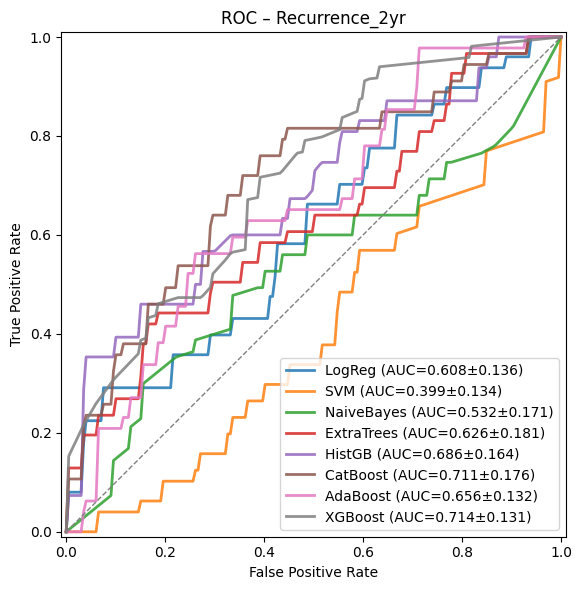

In [149]:
# ╔═╡ Cell 7 – Plot combined ROC figure ─════════════════════════════╗
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, disp in enumerate(roc_displays):
    disp.plot(ax=plt.gca(), alpha=0.85, linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)
plt.title("ROC – Recurrence_2yr")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [150]:
# ╔═╡ Cell 7b – Bootstrap AUC 95% CI ─────────────────────────────────╗
import numpy as np
from sklearn.metrics    import roc_auc_score

# 1) ground truth
y_true = y_test.reset_index(drop=True)

# 2) pipeline handles preprocessing internally
y_prob = models["XGBoost"].predict_proba(
    X_test.reset_index(drop=True)
)[:, 1]

# 3) bootstrap
n_bootstraps = 1000
rng = np.random.RandomState(42)
scores = []

for _ in range(n_bootstraps):
    idx = rng.randint(0, len(y_true), len(y_true))
    if len(np.unique(y_true.iloc[idx])) < 2:
        continue
    scores.append(roc_auc_score(y_true.iloc[idx], y_prob[idx]))

ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
auc_mean = roc_auc_score(y_true, y_prob)

print(f"AUC (test)         = {auc_mean:.3f}")
print(f"95% CI (bootstrap)= [{ci_lower:.3f}, {ci_upper:.3f}]")


AUC (test)         = 0.750
95% CI (bootstrap)= [0.552, 0.901]


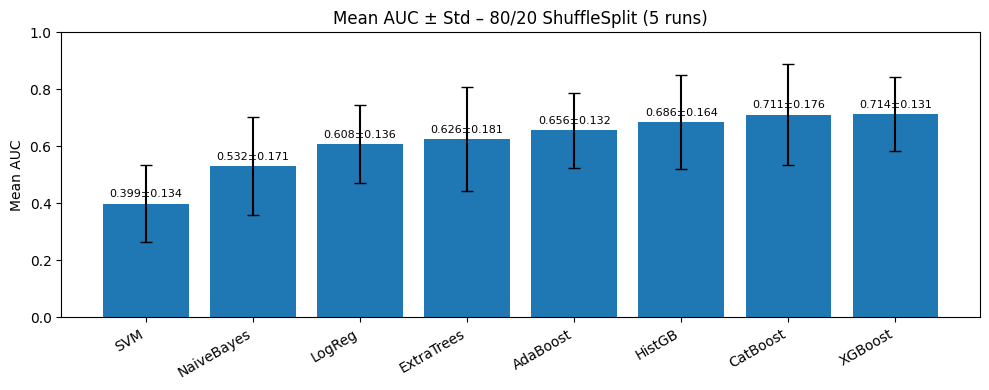

In [151]:
# ╔═╡ Cell 8 – Bar chart of mean ShuffleSplit AUCs with ±std ─════════╗
import numpy as np

# 1. Compute mean & std per model
mean_aucs = {name: np.mean(vals) for name, vals in aucs.items()}
std_aucs  = {name: np.std(vals)  for name, vals in aucs.items()}

# 2. Sort by mean AUC
sorted_items = sorted(mean_aucs.items(), key=lambda kv: kv[1])
labels, means = zip(*sorted_items)
stds = [std_aucs[name] for name in labels]

# 3. Plot bars with error bars
plt.figure(figsize=(10, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=4)
plt.ylim(0, 1)
plt.ylabel("Mean AUC")
plt.title("Mean AUC ± Std – 80/20 ShuffleSplit (5 runs)")
plt.xticks(rotation=30, ha="right")

# 4. Annotate each bar with mean±std
for bar, m, s in zip(bars, means, stds):
    text = f"{m:.3f}±{s:.3f}"
    plt.annotate(
        text,
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3), textcoords="offset points",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()


In [152]:
# ╔═╡ Cell 9 – Quick summary table with mean ± std AUC ─════════════╗
import numpy as np

# Build a list of records
records = []
for name, vals in aucs.items():
    records.append({
        "Model":    name,
        "Mean AUC": np.mean(vals),
        "Std AUC":  np.std(vals)
    })

# Create DataFrame and sort
summary = (
    pd.DataFrame(records)
      .sort_values("Mean AUC", ascending=False)
      .reset_index(drop=True)
)

# Plain‐text print
print(summary.to_string(index=False, float_format="%.3f"))


     Model  Mean AUC  Std AUC
   XGBoost     0.714    0.131
  CatBoost     0.711    0.176
    HistGB     0.686    0.164
  AdaBoost     0.656    0.132
ExtraTrees     0.626    0.181
    LogReg     0.608    0.136
NaiveBayes     0.532    0.171
       SVM     0.399    0.134


In [153]:
# ╔═╡ Cell 10.1 – Pipeline + sigmoid calibration ─────────────────────╗
from sklearn.pipeline            import Pipeline
from sklearn.calibration        import CalibratedClassifierCV
from xgboost                    import XGBClassifier

# 1) Build an XGB pipeline WITHOUT early stopping
#    This uses the same hyperparameters you found in Cell 5.4 (best_params).
xgb_pipe_uncal = Pipeline([
    ("prep", pre_xgb),  # your simple median‐imputer + ordinal‐encoder ColumnTransformer
    ("clf",  XGBClassifier(
        **best_params,               # from your RandomizedSearchCV in Cell 5.4
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
        # <— NO early_stopping_rounds here!
    ))
])

# 2) Wrap in a Platt‐scaler (sigmoid) using 5‐fold CV on the full training set
calibrator = CalibratedClassifierCV(
    estimator=xgb_pipe_uncal,
    method="sigmoid",  # Platt scaling
    cv=5
)

# 3) Fit on your entire training set
calibrator.fit(X_train, y_train)

# 4) Store back into your models dict
models["XGBoost_Calibrated"] = calibrator

print("✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).")


✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).


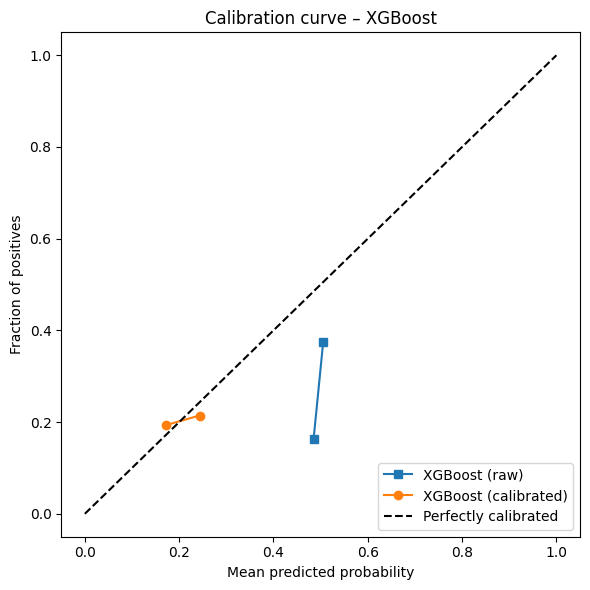

Brier score (raw)     : 0.24063027814615504
Brier score (calibr.) : 0.15609285843900625


In [154]:
# ╔═╡ Cell 10.2 – Calibration curve + Brier score ─────────────────══════╗
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss
import matplotlib.pyplot as plt

# 1) Raw probabilities (before calibration) on the raw X_test
y_prob_raw = models["XGBoost"].predict_proba(X_test)[:, 1]

# 2) Calibrated probabilities (same raw X_test)
y_prob_cal = models["XGBoost_Calibrated"].predict_proba(X_test)[:, 1]

# 3) Compute calibration curves (fraction of positives vs. mean predicted)
frac_pos_raw, mean_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_raw, frac_pos_raw, "s-", label="XGBoost (raw)")
plt.plot(mean_pred_cal, frac_pos_cal, "o-", label="XGBoost (calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Brier scores for raw vs. calibrated
print("Brier score (raw)     :", brier_score_loss(y_test, y_prob_raw))
print("Brier score (calibr.) :", brier_score_loss(y_test, y_prob_cal))


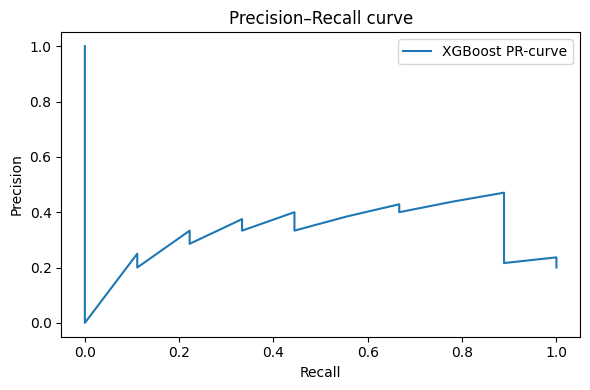

Best F1=0.615 at threshold=0.49


In [155]:
# ╔═╡ Cell 10.3 – Precision–Recall & threshold‐tuning ════════════════╗
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = models["XGBoost"].predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="XGBoost PR-curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()

# F1 vs threshold
f1s = [f1_score(y_test, y_prob>=t) for t in thresholds]
opt_idx = np.argmax(f1s)
print(f"Best F1={f1s[opt_idx]:.3f} at threshold={thresholds[opt_idx]:.2f}")


<ipython-input-158-9a3e417dc431>:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


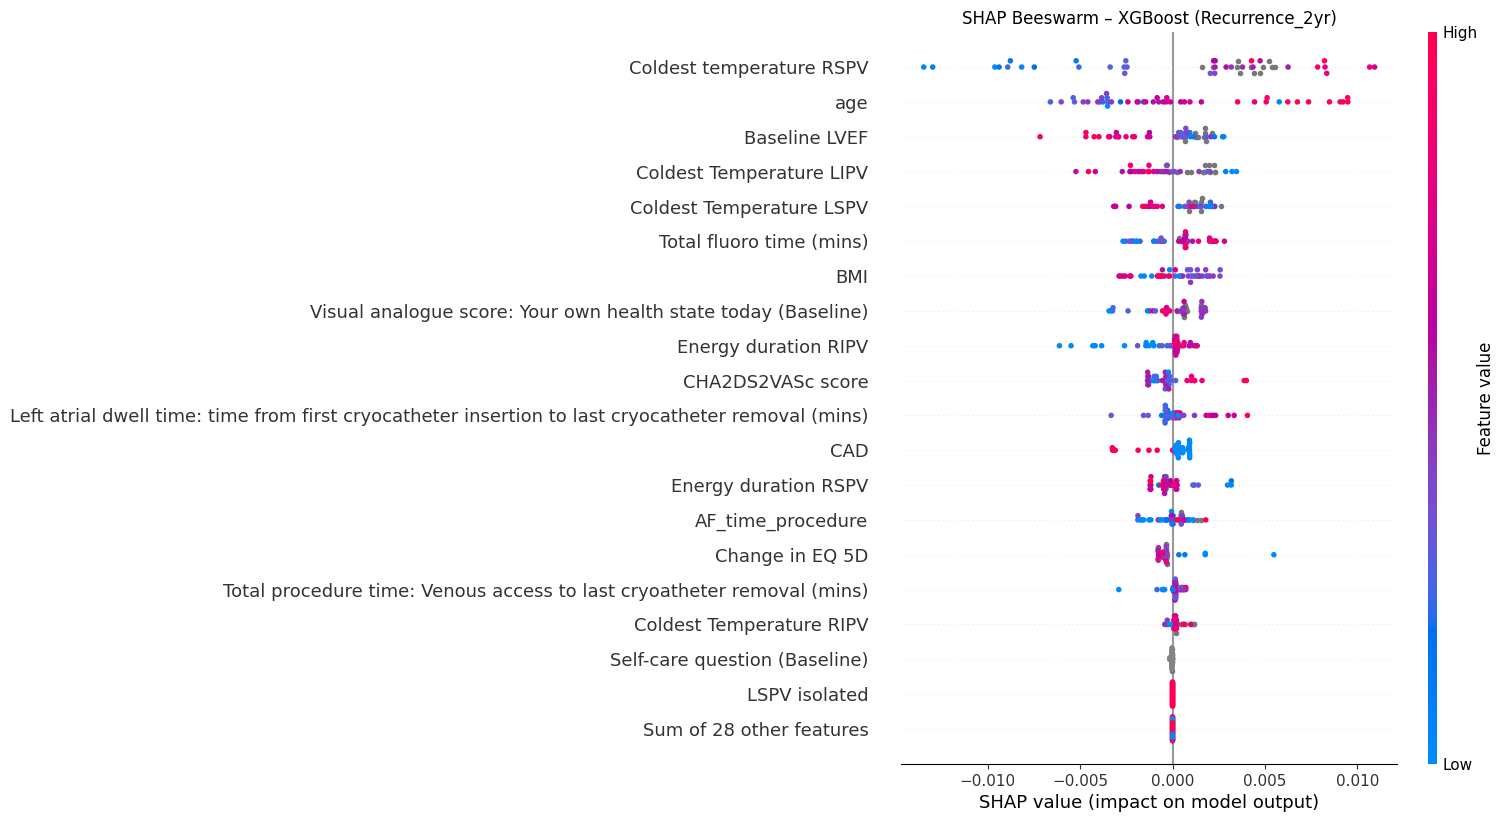

<ipython-input-158-9a3e417dc431>:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


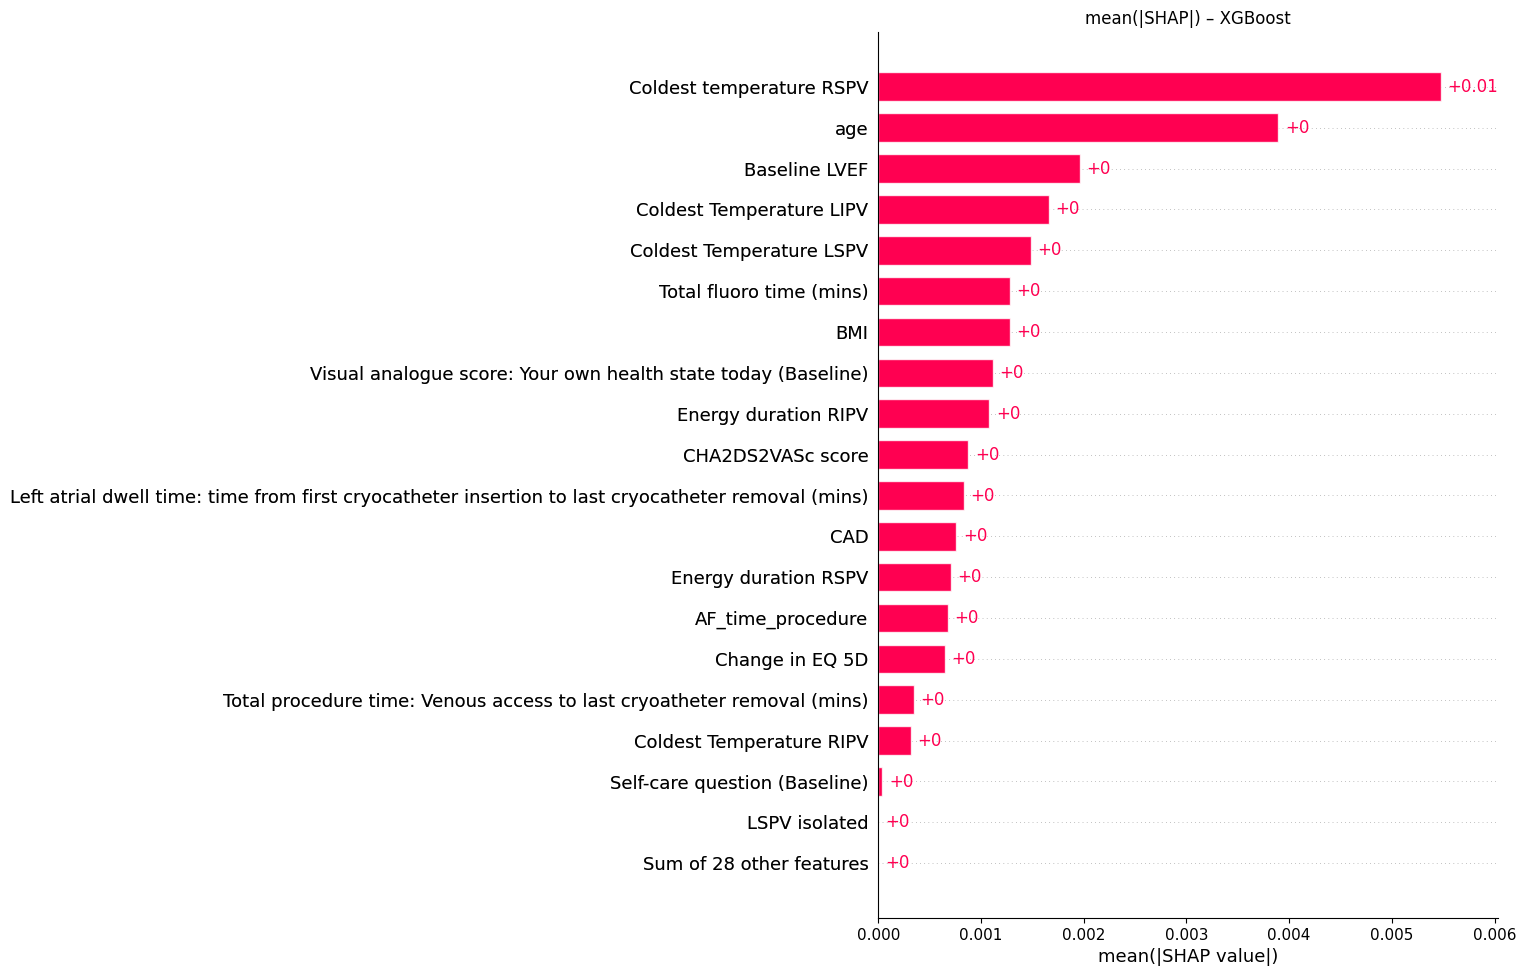

In [158]:
# ╔═╡ Cell 10.4 – SHAP summary (model-agnostic) ─────────────────══════╗
import shap
import matplotlib.pyplot as plt

# 1) Make a simple function that takes a DataFrame X and returns P(y=1)
def model_proba(df):
    return models["XGBoost"].predict_proba(df)[:, 1]

# 2) Build the explainer on your training DataFrame
explainer = shap.Explainer(model_proba, X_train)

# 3) Compute SHAP values on your held-out test set
shap_values = explainer(X_test)

# 4) Beeswarm (dot) summary
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("SHAP Beeswarm – XGBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 5) Bar plot of mean(|SHAP|)
plt.figure(figsize=(6, 8))
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title("mean(|SHAP|) – XGBoost")
plt.tight_layout()
plt.show()


Top 3 features by |SHAP|: ['Coldest temperature RSPV', 'age', 'Baseline LVEF']


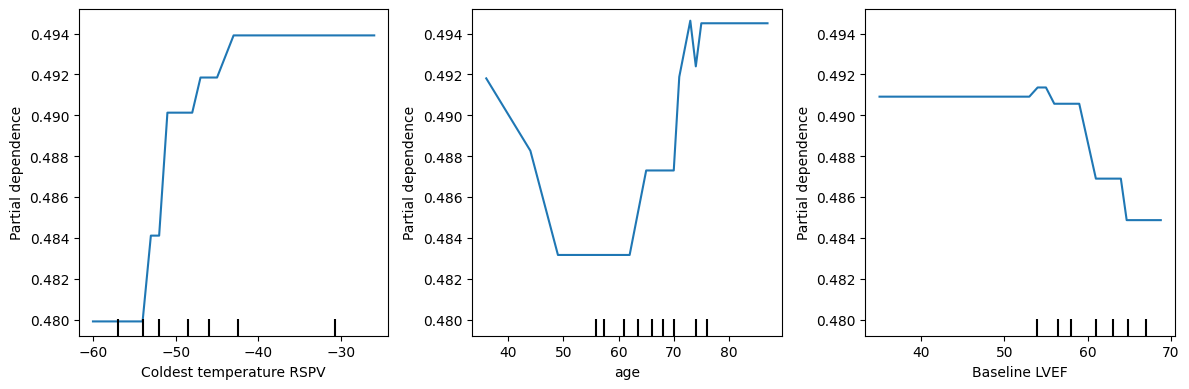

In [159]:
# ╔═╡ Cell 10.5 – Partial dependence for top features ═══════════════╗
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) Extract the raw SHAP values array from the Explanation
#    shap_values was created in Cell 10 via `explainer(X_test)`
vals = shap_values.values
# If it’s a 3‐D array (n_samples x 2 classes x n_features),
# pick the positive‐class slice:
if vals.ndim == 3:
    vals = vals[:, 1, :]

# 2) Compute mean(|SHAP|) per feature and grab top-3 indices
importances = np.abs(vals).mean(axis=0)
top_idx    = np.argsort(importances)[::-1][:3]
top_feats  = [X_test.columns[i] for i in top_idx]

print("Top 3 features by |SHAP|:", top_feats)

# 3) Plot partial dependence for those top 3
fig, axes = plt.subplots(1, len(top_feats), figsize=(4*len(top_feats), 4))
PartialDependenceDisplay.from_estimator(
    models["XGBoost"],
    X_test,
    features=top_feats,
    ax=axes
)
plt.tight_layout()
plt.show()


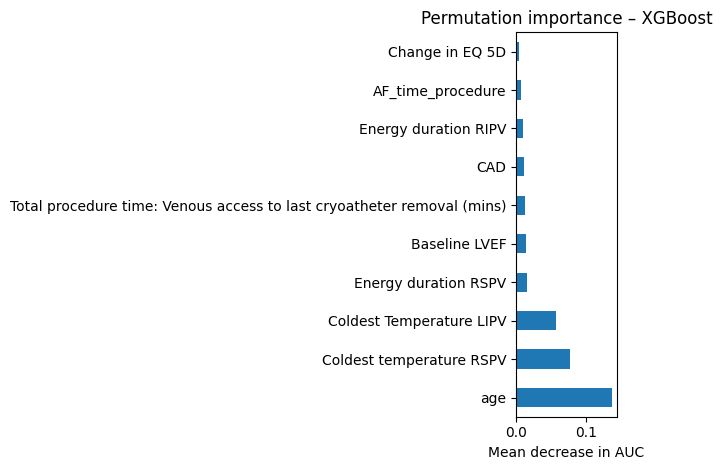

In [160]:
# ╔═╡ Cell 10.6 – Permutation importance ══════════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["XGBoost"], X_test, y_test,
    scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE
)
perm_df = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_df.head(10).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – XGBoost")
plt.tight_layout()
plt.show()

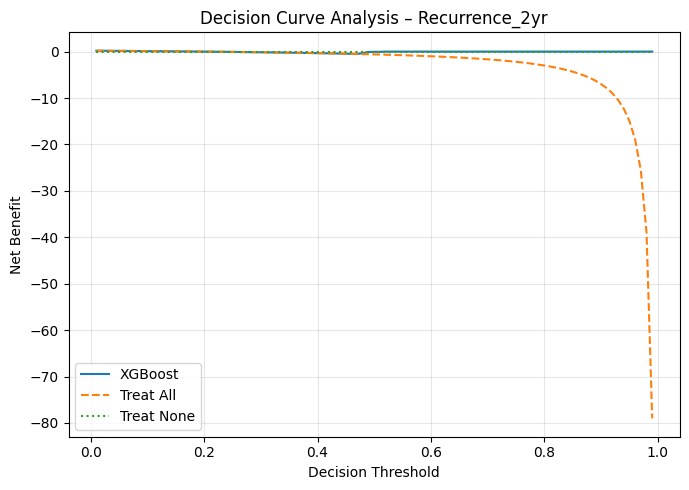

In [161]:
# ╔═╡ Cell 10.7 – Manual Decision Curve Analysis (Net Benefit) ─════════════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) True labels & predicted probabilities (from your best model)
y_true = y_test.values        # shape (n_samples,)
y_prob = models["XGBoost"].predict_proba(X_test)[:,1]

N      = len(y_true)
preval = y_true.mean()        # event rate

# 2) Define a grid of thresholds
thresholds = np.linspace(0.01, 0.99, 99)

# 3) Compute net benefit for each threshold
nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for pt in thresholds:
    preds = (y_prob >= pt).astype(int)
    TP    = ((preds == 1) & (y_true == 1)).sum()
    FP    = ((preds == 1) & (y_true == 0)).sum()
    # NB = TP/N - FP/N * (pt/(1-pt))
    nb    = TP/N - FP/N * (pt/(1-pt))
    nb_model.append(nb)
    nb_all.append(preval - (1 - preval)*(pt/(1-pt)))

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, nb_model, label="XGBoost")
plt.plot(thresholds, nb_all,   label="Treat All",    linestyle="--")
plt.plot(thresholds, nb_none,  label="Treat None",   linestyle=":")
plt.xlabel("Decision Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – Recurrence_2yr")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Final AUC:             0.75
Confusion matrix (0.5):
 [[31  5]
 [ 6  3]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        36
           1       0.38      0.33      0.35         9

    accuracy                           0.76        45
   macro avg       0.61      0.60      0.60        45
weighted avg       0.75      0.76      0.75        45



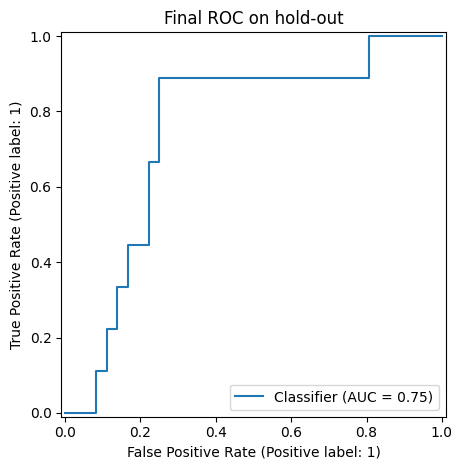

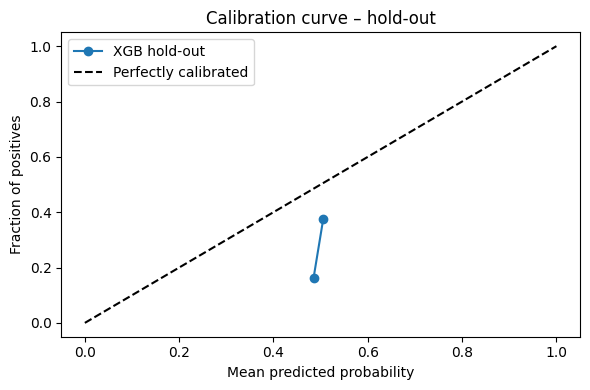

Final Brier score: 0.24063027814615504
Optimal threshold (max Youden's J): 0.491


In [168]:
# ╔═╡ Cell 10.8 – Final evaluation on future hold‐out ═══════════════════╗
from sklearn.metrics       import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    brier_score_loss,
    roc_curve
)
from sklearn.calibration   import calibration_curve
import matplotlib.pyplot   as plt
import numpy              as np

# 1) Pick your final model
best_model    = models["XGBoost"]    # or "XGBoost_Calibrated"
X_val, y_val  = X_test, y_test

# 2) Predicted probabilities & hard labels
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred  = best_model.predict(X_val)

# 3) Print metrics
print("Final AUC:            ", roc_auc_score(y_val, y_val_proba))
print("Confusion matrix (0.5):\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

# 4) ROC curve
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("Final ROC on hold‐out")
plt.tight_layout()
plt.show()

# 5) Calibration curve & Brier score
frac_pos, mean_pred = calibration_curve(y_val, y_val_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, "o-", label="XGB hold‐out")
plt.plot([0, 1], [0, 1], "k--",  label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – hold‐out")
plt.legend()
plt.tight_layout()
plt.show()

print("Final Brier score:", brier_score_loss(y_val, y_val_proba))

# 6) Optimal threshold via Youden’s J
fpr, tpr, thresh = roc_curve(y_val, y_val_proba)
j_scores         = tpr - fpr
best_thresh      = thresh[np.argmax(j_scores)]
print(f"Optimal threshold (max Youden's J): {best_thresh:.3f}")


🔎 SHAP values shape: (45, 75)


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-163-07646441a5c1>:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


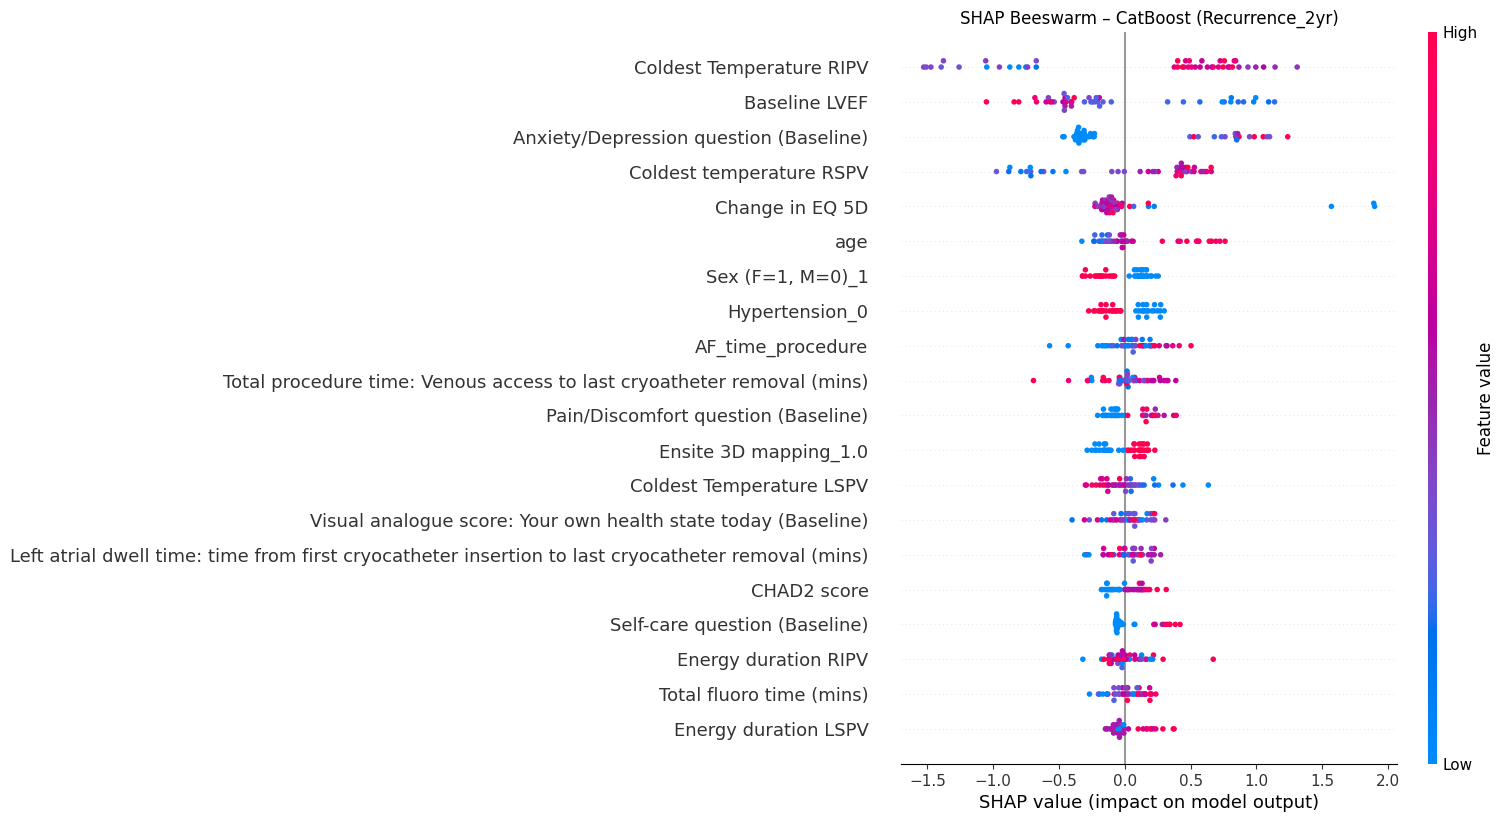

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
<ipython-input-163-07646441a5c1>:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


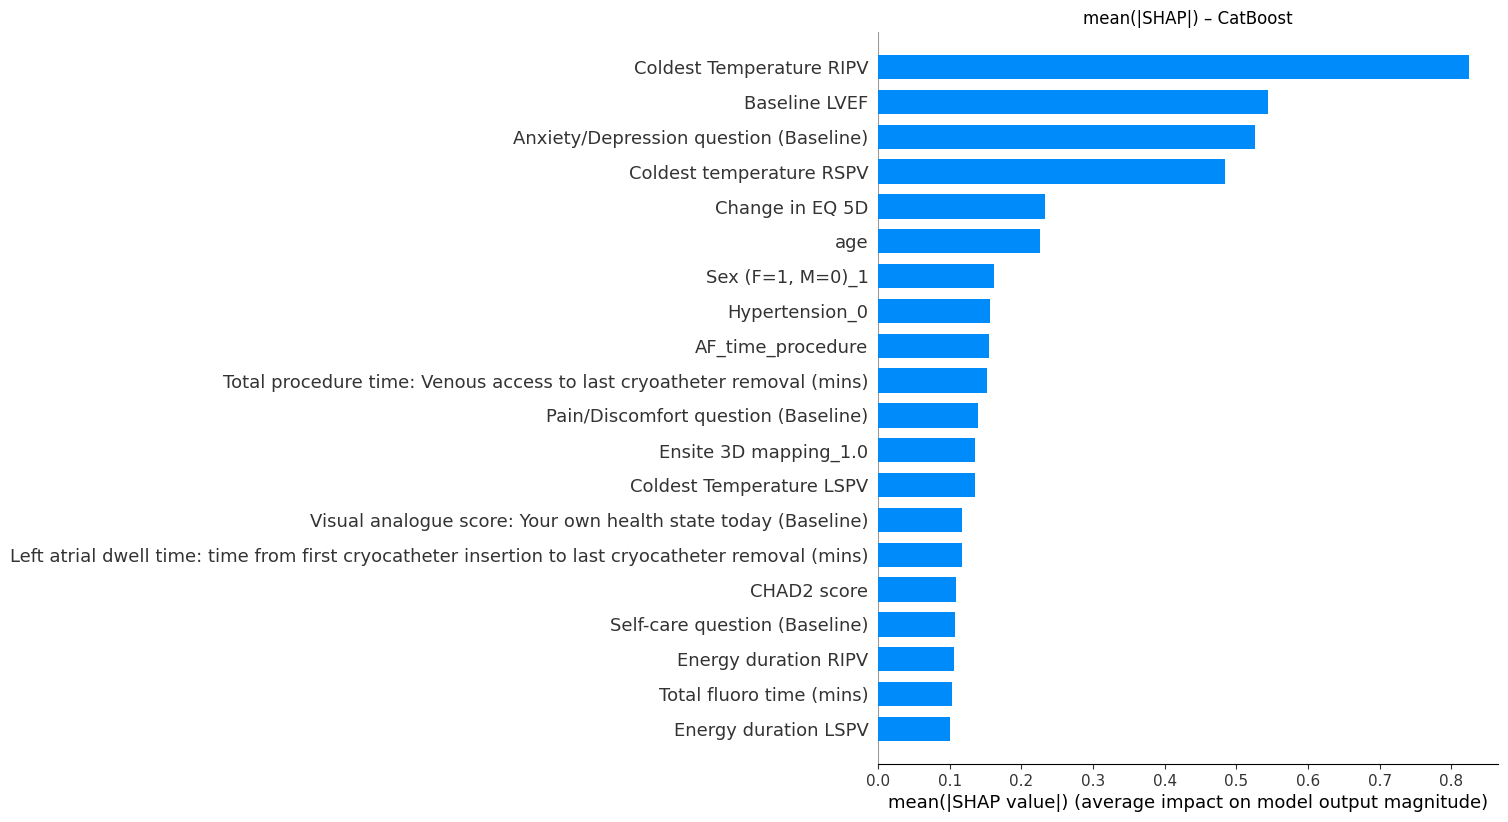

In [163]:
# ╔═╡ Cell 11.0 – SHAP summary for CatBoost (Recurrence_2yr) ─════════════╗
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Extract the preprocessor and the plain CatBoost model:
cb_pipe  = models["CatBoost"]
prep     = cb_pipe.named_steps["prep"]     # your ColumnTransformer
cb_model = cb_pipe.named_steps["clf"]      # the CatBoostClassifier itself

# 2) Transform train & test to the numeric arrays that the CB model was trained on
X_train_pre = prep.transform(X_train)
X_test_pre  = prep.transform(X_test)

# 3) Build a TreeExplainer with background data = your preprocessed train set
explainer_cb = shap.TreeExplainer(cb_model, X_train_pre)

# 4) Compute SHAP values on the hold-out
shap_values_cb = explainer_cb.shap_values(X_test_pre)
print("🔎 SHAP values shape:", np.array(shap_values_cb).shape)

# 5) Reconstruct feature names: cont + one-hot cats
ohe          = categorical_pipe.named_steps["onehot"]
cat_ohe_names = ohe.get_feature_names_out(cat)
feat_names    = cont + list(cat_ohe_names)

# 6) Beeswarm (dot) summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_cb,
    X_test_pre,
    feature_names=feat_names,
    max_display=20,
    show=False
)
plt.title("SHAP Beeswarm – CatBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 7) Bar plot of mean(|SHAP|)
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values_cb,
    X_test_pre,
    feature_names=feat_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("mean(|SHAP|) – CatBoost")
plt.tight_layout()
plt.show()


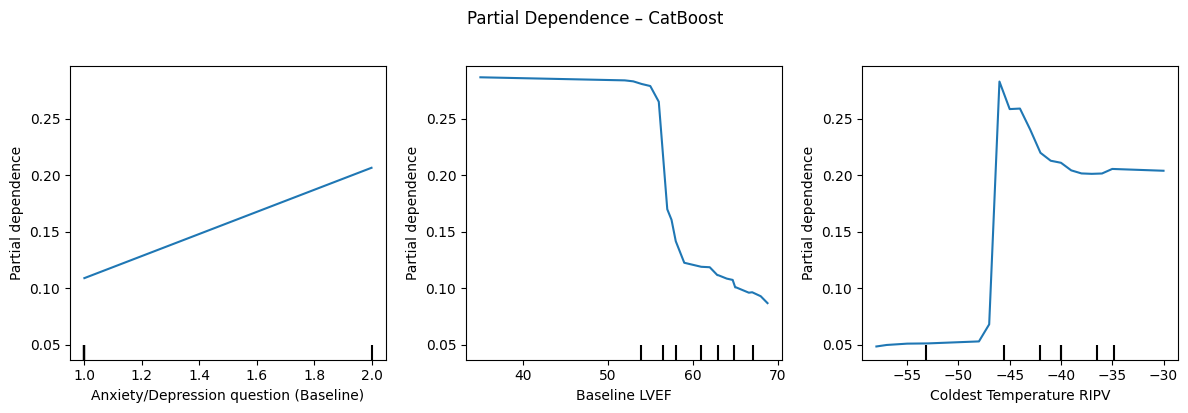

In [164]:
# ╔═╡ Cell 11.1 – Partial dependence (top 3 CatBoost features) ═════════╗
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# pick the top 3 by mean(|SHAP|)
top3 = X_test_cb.columns[np.argsort(np.abs(shap_values_cb).mean(0))[-3:]]

fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
PartialDependenceDisplay.from_estimator(
    models["CatBoost"],      # your final CatBoost instance
    X_test_cb,               # preprocessed test set
    features=list(top3),     # names of the top 3
    ax=axes
)
plt.suptitle("Partial Dependence – CatBoost", y=1.02)
plt.tight_layout()
plt.show()


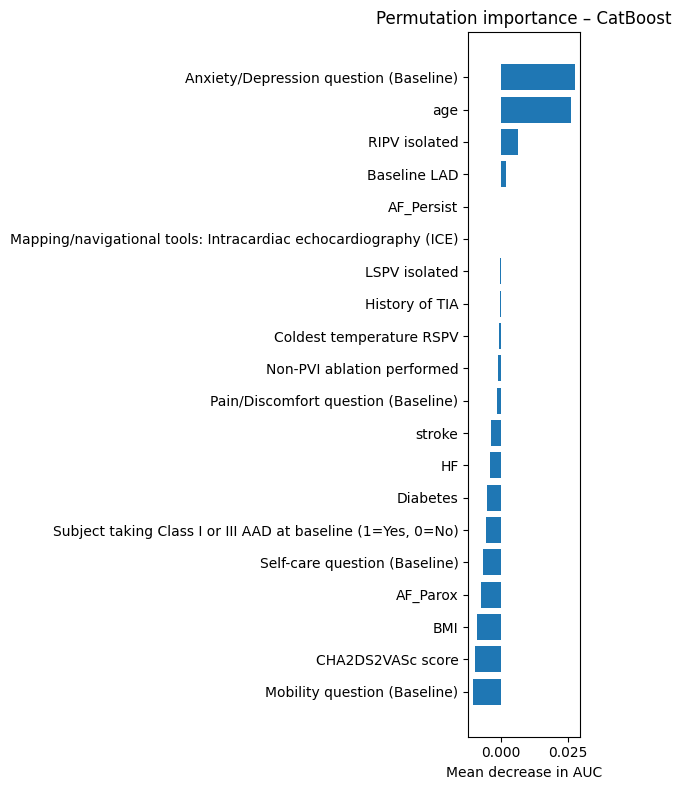

In [165]:
# ╔═╡ Cell 11.2 – Permutation importance (CatBoost) ═════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["CatBoost"],
    X_test_cb, y_test,
    scoring="roc_auc",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# sort and plot
import pandas as pd
imp_df = pd.DataFrame({
    "feature": X_test_cb.columns,
    "mean_decrease_auc": r.importances_mean
}).sort_values("mean_decrease_auc", ascending=False).head(20)

plt.figure(figsize=(6,8))
plt.barh(imp_df["feature"][::-1], imp_df["mean_decrease_auc"][::-1])
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – CatBoost")
plt.tight_layout()
plt.show()


<ipython-input-166-d7bdedcd9c39>:16: RuntimeWarning: divide by zero encountered in scalar divide
  nb.append((tp/n) - (fp/n)*(t/(1-t)))  # simple net‐benefit formula
<ipython-input-166-d7bdedcd9c39>:16: RuntimeWarning: invalid value encountered in scalar multiply
  nb.append((tp/n) - (fp/n)*(t/(1-t)))  # simple net‐benefit formula
<ipython-input-166-d7bdedcd9c39>:21: RuntimeWarning: divide by zero encountered in divide
  event_rate - (1-event_rate)*(thresholds/(1-thresholds)),


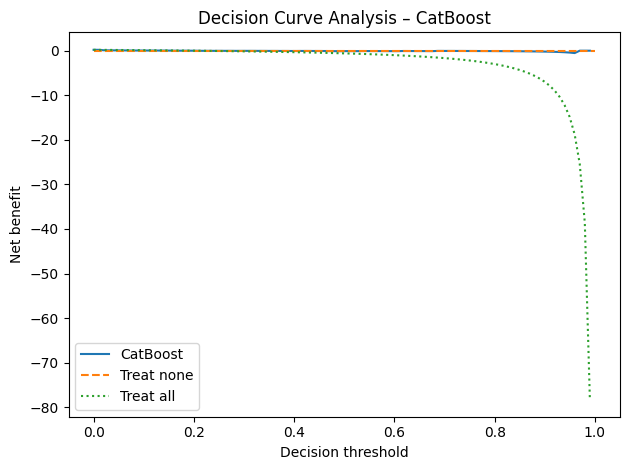

In [166]:
# ╔═╡ Cell 11.3 – Decision curve (CatBoost) ─────────────────────────────╗
import numpy as np
from sklearn.metrics import roc_curve

# (you can reuse your decision‐curve function or library)
# here’s a very simple “net benefit” curve for illustration:
probs = models["CatBoost"].predict_proba(X_test_cb)[:,1]
thresholds = np.linspace(0,1,100)
n = len(y_test)
event_rate = y_test.mean()

nb = []
for t in thresholds:
    tp = ((probs >= t) & (y_test==1)).sum()
    fp = ((probs >= t) & (y_test==0)).sum()
    nb.append((tp/n) - (fp/n)*(t/(1-t)))  # simple net‐benefit formula

plt.plot(thresholds, nb, label="CatBoost")
plt.plot(thresholds, np.zeros_like(thresholds), '--', label="Treat none")
plt.plot(thresholds,
         event_rate - (1-event_rate)*(thresholds/(1-thresholds)),
         ':', label="Treat all")
plt.xlabel("Decision threshold")
plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis – CatBoost")
plt.legend()
plt.tight_layout()
plt.show()


CatBoost AUC:           0.4845679012345679
CatBoost Confusion @0.5:
 [[31  5]
 [ 9  0]]

CatBoost Classification report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        36
           1       0.00      0.00      0.00         9

    accuracy                           0.69        45
   macro avg       0.39      0.43      0.41        45
weighted avg       0.62      0.69      0.65        45



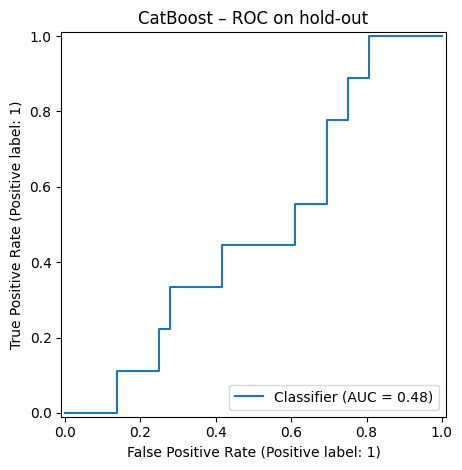

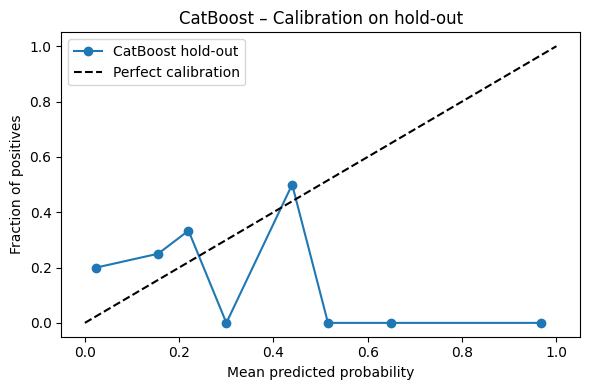

CatBoost Brier score: 0.22361544358191765
CatBoost optimal threshold (max J): 0.010


In [169]:
# ╔═╡ Cell 11.4 – Final evaluation on future hold-out for CatBoost ─════════╗
from sklearn.metrics       import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
from sklearn.calibration   import calibration_curve
from sklearn.metrics       import brier_score_loss
import matplotlib.pyplot   as plt
import numpy as np

# 1) Pick your CatBoost pipeline and your future hold-out
best_cb    = models["CatBoost"]
X_val, y_val = X_test, y_test

# 2) Predict probabilities & hard labels
#    (your pipeline already handles all preprocessing)
y_val_proba_cb = best_cb.predict_proba(X_val)[:, 1]
y_val_pred_cb  = best_cb.predict(X_val)

# 3) Print out discrimination & classification metrics
print("CatBoost AUC:          ", roc_auc_score(y_val, y_val_proba_cb))
print("CatBoost Confusion @0.5:\n", confusion_matrix(y_val, y_val_pred_cb))
print("\nCatBoost Classification report:\n",
      classification_report(y_val, y_val_pred_cb))

# 4) ROC curve
RocCurveDisplay.from_predictions(y_val, y_val_proba_cb)
plt.title("CatBoost – ROC on hold-out")
plt.tight_layout()
plt.show()

# 5) Calibration curve + Brier score
frac_pos, mean_pred = calibration_curve(y_val, y_val_proba_cb, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, "o-", label="CatBoost hold-out")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("CatBoost – Calibration on hold-out")
plt.legend()
plt.tight_layout()
plt.show()

print("CatBoost Brier score:", brier_score_loss(y_val, y_val_proba_cb))

# 6) Pick optimal threshold via Youden’s J
from sklearn.metrics import roc_curve
fpr_cb, tpr_cb, thresh_cb = roc_curve(y_val, y_val_proba_cb)
j_scores_cb = tpr_cb - fpr_cb
best_thresh_cb = thresh_cb[np.argmax(j_scores_cb)]
print(f"CatBoost optimal threshold (max J): {best_thresh_cb:.3f}")
